In [1]:
%matplotlib inline
from SeisCL import SeisCL
import matplotlib.pyplot as plt
import numpy as np

/Users/gabrielfabien-ouellet/anaconda/envs/python3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Source signature inversion

SeisCL can invert for the source signature. The approach is described in:

    Pratt, R. G. (1999). "Seismic waveform inversion in the frequency domain, Part 1: Theory and verification in a physical scale model." Geophysics 64(3): 888-901. https://doi.org/10.1190/1.1444597

## Theory
    
We consider the wave equation in the frequency domain, which can be succintly written as:

$$\pmb{F}_\omega \pmb{d}_\omega = a_\omega\pmb{s}_\omega$$

$\pmb{d}_\omega$ is the measured data at the recording position (pressure or particle velocities),
$\pmb{F}_\omega$ is the discretized wave operator in the frequency domain, and
$\pmb{s}_\omega$ is the initial source vector that we want to transform by multiplying it by a complex constant $a_\omega$ so to recover the true source signature. Note that this equation is for a frequency $\omega$. The recorded data for a given source is given by

$$\pmb{d}_\omega = a_\omega\pmb{F}^{-1}_\omega\pmb{s}_\omega$$.

The method for solving this system is irrelevant at this point. To find the coefficients $a_\omega$, we minimize to usual FWI cost function:  

$$\mathcal{X}_\omega = \frac{1}{2}(\pmb{d}_\omega-\pmb{d}^0_\omega)^*(\pmb{d}-\pmb{d}^0_\omega)$$

$\pmb{d}^0_\omega$ is the observed data and $^*$ stand for the conjugate transpose. To minimize, the derivative of the cost respect to $a_\omega$ should be zero:

$$\frac{\partial \mathcal{X}_\omega}{\partial a_\omega}  = (\pmb{F}^{-1}_\omega\pmb{s}_\omega)^*(a_\omega\pmb{F}^{-1}_\omega\pmb{s}_\omega-\pmb{d}^0_\omega) = 0$$

which gives:

$$a_\omega = \frac{\pmb{d}_\omega^*\pmb{d}^0_\omega}{\pmb{d}_\omega^*\pmb{d}_\omega}$$

Given the solution in the time domain, we can update the source signature as follows:

$$\pmb{s}_{updated} = \mathcal{F}^{-1} \left( \frac{\mathcal{F}(\pmb{d})^* \mathcal{F}(\pmb{d}^0)}{\mathcal{F}(\pmb{d})^*\mathcal{F}(\pmb{d})}     \mathcal{F}(\pmb{s})\right)$$

where $\mathcal{F}$ stands for the Fourier transform in time. As the data is a linear function of the source, this equation converges in one iteration. 

## Source signature inversion with SeisCL

We can invert the source signature with the SeisCL python interface. We show this with a brief example. We first set up the modeling parameters and receivers and source positions.

In [2]:
seis = SeisCL()

# Constants for the modeling
N = 200
seis.csts["N"] = np.array([N, N])
seis.csts['ND'] = 2
seis.csts['dt'] = 0.25e-03
seis.csts['NT'] = 1000
seis.csts['dh'] = dh= 2
seis.csts['f0'] = 20
seis.csts['freesurf'] = 0

# Source and receiver positions
sx = N//2 * dh
sy = 0
sz = N//2 * dh
gx = np.arange(N//4 * dh, (N - N//4)*dh, dh)
gy = gx * 0
gz = gx * 0 + N//4*dh
gsid = gz * 0
gid = np.arange(0, len(gz))
seis.src_pos_all = np.stack([[sx], [sy], [sz], [0], [0]], axis=0)
seis.rec_pos_all = np.stack([gx, gy, gz, gsid, gid, gx * 0, gx * 0, gx * 0], axis=0)
  
# We start with a simple model
vp_a = np.zeros(seis.csts["N"]) + 3500
vs_a = np.zeros(seis.csts["N"]) + 2000
rho_a = np.zeros(seis.csts["N"]) + 2000


Note that source is by default a Ricker wavelet with a central frequency of seis.csts['f0'], so 20 Hz here. We then generate a synthetic shot, which will serve as the observed data $\pmb{d}^0$.

In [3]:
seis.set_forward(seis.src_pos_all[3, :], {"vp": vp_a, "rho": rho_a, "vs": vs_a}, withgrad=False)
seis.execute()
data = seis.read_data()
src1 = seis._src

We can then change the frequency of the source to 15 Hz and recompute the data with the bad source signature.

In [4]:
seis.csts["f0"] = 15
seis.src_all = None

seis.set_forward(seis.src_pos_all[3, :], {"vp": vp_a, "rho": rho_a, "vs": vs_a}, withgrad=False)
seis.execute()
data2 = seis.read_data()
src2 = seis._src

We we look at the observed data and the modeled data, they indeed have a different source signature

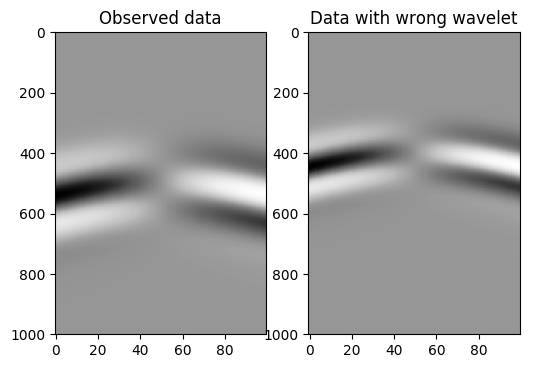

In [17]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(data2[0], aspect='auto', cmap=plt.get_cmap('Greys'))
ax[0].set_title("Observed data")
ax[1].imshow(data[0], aspect='auto', cmap=plt.get_cmap('Greys'))
ax[1].set_title("Data with wrong wavelet")
plt.show()

We can then call the source inversion routine of SeisCL, which needs the source to be updated, the observed data and the modelled data. If we provide a source id, it will overwrite the source function for this srcid with the new wavelet.

In [19]:
src3 = seis.invert_source(src2, data[0], data2[0], srcid=0)

The source function contained in seis.src_all is now the corrected wavelet, which is the same as the initial, that is a ricker wavelet of 20 Hz.

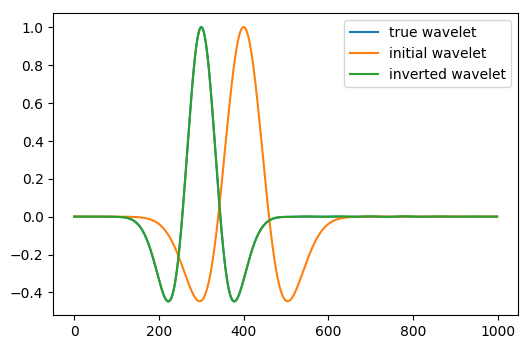

In [20]:
plt.plot(src1, label="true wavelet")
plt.plot(src2, label="initial wavelet")
plt.plot(seis.src_all[:,0], label="inverted wavelet")
plt.legend()
plt.show()